In [134]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [135]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
demand_ts = demand_data['demand']

In [136]:
#agrupamos los dias por semanas
demand_ts  = demand_data['demand'].resample('W').sum()

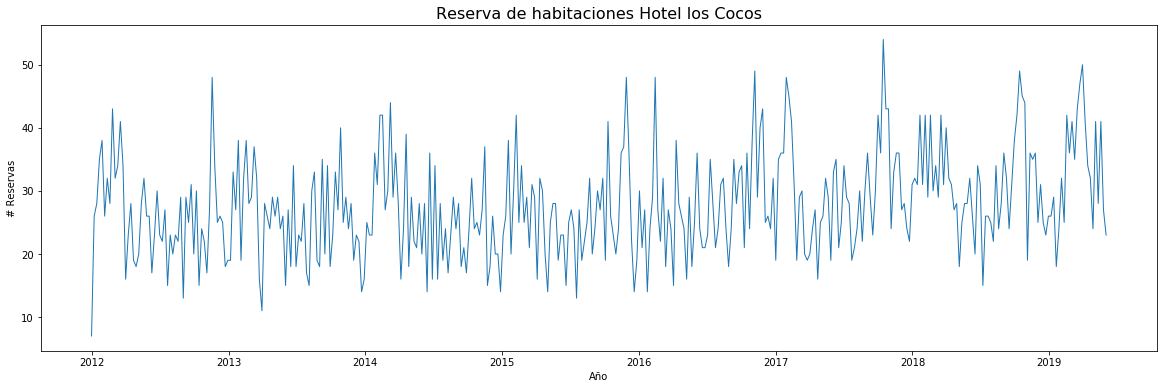

In [137]:
#Plot
plt.plot(demand_ts, linewidth=1)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [145]:
#demand_ts['2012':'2018']

In [159]:
TS = np.array(demand_data['demand'].resample('W').sum())
num_periods = 52
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 1, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 1, 1)

In [160]:
#TS

In [161]:
print("x_data:")
#print(x_data)

print("\n x_batches:")
#print(x_batches)
print("\n x_batches shape:")
print(x_batches.shape)

print("\n y_data]:")
#print(y_data)

print("\n y_batches:")
#print(y_batches)
print("\n y_batches shape:")
print(y_batches.shape)

x_data:

 x_batches:

 x_batches shape:
(364, 1, 1)

 y_data]:

 y_batches:

 y_batches shape:
(364, 1, 1)


In [162]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 1, 1)
    testY = TS[-(num_periods):].reshape(-1, 1, 1)
    return testX,testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)

print("\n X shape")
print(X_test.shape)

print("\n Y shape")
print(Y_test.shape)

print("\n X_test")
print(X_test)


 X shape
(52, 1, 1)

 Y shape
(52, 1, 1)

 X_test
[[[32]]

 [[26]]

 [[20]]

 [[34]]

 [[31]]

 [[15]]

 [[26]]

 [[26]]

 [[25]]

 [[22]]

 [[34]]

 [[24]]

 [[28]]

 [[36]]

 [[32]]

 [[24]]

 [[31]]

 [[38]]

 [[42]]

 [[49]]

 [[45]]

 [[44]]

 [[19]]

 [[36]]

 [[35]]

 [[36]]

 [[25]]

 [[31]]

 [[25]]

 [[23]]

 [[26]]

 [[26]]

 [[29]]

 [[18]]

 [[24]]

 [[32]]

 [[25]]

 [[42]]

 [[36]]

 [[41]]

 [[35]]

 [[43]]

 [[47]]

 [[50]]

 [[41]]

 [[34]]

 [[32]]

 [[24]]

 [[41]]

 [[28]]

 [[41]]

 [[27]]]


In [163]:
tf.reset_default_graph()

num_periods = 1
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

#BasicRNNCell
#BasicLSTMCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])


loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [164]:
epochs = 2000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 287624.4
100 	MSE: 40998.465
200 	MSE: 35448.426
300 	MSE: 29049.004
400 	MSE: 24280.752
500 	MSE: 21949.916
600 	MSE: 21127.373
700 	MSE: 20771.05
800 	MSE: 20560.826
900 	MSE: 20425.611
1000 	MSE: 20336.482
1100 	MSE: 20277.715
1200 	MSE: 20239.379
1300 	MSE: 20214.732
1400 	MSE: 20199.086
1500 	MSE: 20189.186
1600 	MSE: 20182.775
1700 	MSE: 20178.072
1800 	MSE: 20173.816
1900 	MSE: 20169.81


In [168]:
indDates1 = pd.date_range(start = '2012-01-01', periods=366, freq='W')
indDates2 = pd.date_range(start = '2019-01-06', periods=len(Y_test), freq='W')


In [176]:
#Xtest = pd.DataFrame(X_test.ravel(), index=indDates1)
#Xtest

In [177]:
Ytest = pd.DataFrame(Y_test.ravel(), index=indDates2)
#Ytest

In [178]:
YPred = pd.DataFrame(y_pred.ravel(), index=indDates2)
#YPred

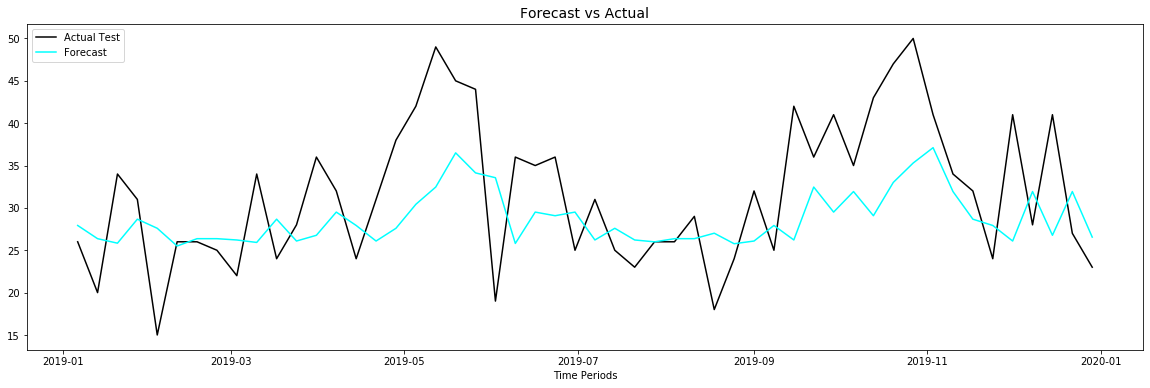

In [179]:
plt.title("Forecast vs Actual", fontsize=14)
#plt.plot( Xtest, 'blue', label="X Test")
plt.plot( Ytest, 'black', label="Actual Test")
plt.plot( YPred, 'cyan', label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

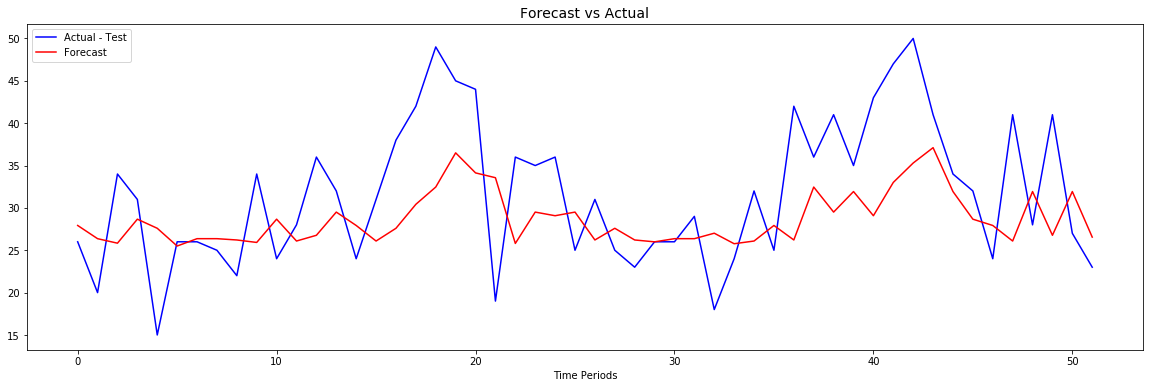

In [180]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', label="Actual - Test")
plt.plot(pd.Series(np.ravel(y_pred)), 'r', label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

In [186]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [187]:
mean_absolute_percentage_error(Y_test,y_pred )

20.407628179498648

In [183]:
YPred

,0
2019-01-06,27.926338
2019-01-13,26.367329
2019-01-20,25.834976
2019-01-27,28.668921
2019-02-03,27.593811
2019-02-10,25.499287
2019-02-17,26.367329
2019-02-24,26.367329
2019-03-03,26.213638
2019-03-10,25.922314
